In [10]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os

In [11]:
df = pd.read_csv('../input/state-farm-distracted-driver-detection/driver_imgs_list.csv')
df.head(5)


,subject,classname,img
0,p002,c0,img_44733.jpg
1,p002,c0,img_72999.jpg
2,p002,c0,img_25094.jpg
3,p002,c0,img_69092.jpg
4,p002,c0,img_92629.jpg


In [12]:
len(df)

22424

#SPLIT INTO TRAIN AND TEST

In [13]:
#https://stackoverflow.com/questions/24147278/how-do-i-create-test-and-train-samples-from-one-dataframe-with-pandas
df = df.sample(frac = 1)
tt = np.random.rand(len(df)) < 0.8
train_data = df[tt]
test_data = df[~tt]
print("Train dataset lenght",len(train_data))
print("Test dataset lenght",len(test_data))

Train dataset lenght 17993
Test dataset lenght 4431


The 10 classes to predict are:

c0: normal driving
c1: texting - right
c2: talking on the phone - right
c3: texting - left
c4: talking on the phone - left
c5: operating the radio
c6: drinking
c7: reaching behind
c8: hair and makeup
c9: talking to passenger

In [14]:
types = {'c0': 'normal driving', 
        'c1': 'texting - right', 
        'c2': 'talking on the phone - right', 
        'c3': 'texting - left', 
        'c4': 'talking on the phone - left', 
        'c5': 'operating the radio', 
        'c6': 'drinking', 
        'c7': 'reaching behind', 
        'c8': 'hair and makeup', 
        'c9': 'talking to passenger'}
number_of_class = 10 

LOADING IMAGE IN GRAYSCALE

In [15]:
#https://towardsdatascience.com/convolution-neural-network-for-image-processing-using-keras-dc3429056306

import cv2

def grayscale(path):
    img = cv2.imread(path, 0)
    img = cv2.resize(img, (64, 64))#reduce the size of the image
    return img 

GET train images and their label from the files

In [16]:
from tqdm import tqdm
from glob import glob

def loadtrain():
    train_images = [] 
    train_labels = []
    for classed in tqdm(range(number_of_class)):
        print('Loading directory c{}'.format(classed))
        files = glob(os.path.join('../input/state-farm-distracted-driver-detection/imgs/train/c' + str(classed), '*.jpg'))
        for file in files:
            img = grayscale(file)
            train_images.append(img)
            train_labels.append(classed)
    return train_images, train_labels 

MAKING VALIDATION DATASET FROM TRAIN DATASET

In [17]:
##https://www.kaggle.com/pierrelouisdanieau/computer-vision-tips-to-increase-accuracy

from sklearn.model_selection import train_test_split
from keras.utils import np_utils

def normalize_train_data():
    X, labels = loadtrain()
    y = np_utils.to_categorical(labels, 10)
    x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    x_train = np.array(x_train, dtype=np.uint8).reshape(-1,64,64,1)
    x_test = np.array(x_test, dtype=np.uint8).reshape(-1,64,64,1)

    return x_train, x_test, y_train, y_test

def loadvalid(size=200000):
    path = os.path.join('..', 'input', 'test', '*.jpg')
    files = sorted(glob(path))
    X_test = []
    X_test_id = []
    total = 0
    files_size = len(files)
    for file in tqdm(files):
        if total >= size or total >= files_size:
            break
        file_base = os.path.basename(file)
        img = grayscale(file)
        X_test.append(img)
        X_test_id.append(file_base)
        total += 1
    return X_test, X_test_id

def normalize_valid_data(size):
    test_data, test_ids = loadvalid(size)   
    test_data = np.array(test_data, dtype=np.uint8)
    test_data = test_data.reshape(-1,64,64,1)
    return test_data, test_ids


In [18]:
sample = 200

x_train, x_test, y_train, y_test = normalize_train_data()

# loading validation images
test_files, test_targets = normalize_valid_data(sample)

  0%|          | 0/10 [00:00<?, ?it/s]

Loading directory c0


 10%|█         | 1/10 [00:05<00:52,  5.84s/it]

Loading directory c1


 20%|██        | 2/10 [00:23<01:43, 12.92s/it]

Loading directory c2


 30%|███       | 3/10 [00:43<01:51, 15.99s/it]

Loading directory c3


 40%|████      | 4/10 [01:03<01:45, 17.50s/it]

Loading directory c4


 50%|█████     | 5/10 [01:22<01:31, 18.23s/it]

Loading directory c5


 60%|██████    | 6/10 [01:42<01:14, 18.66s/it]

Loading directory c6


 70%|███████   | 7/10 [02:01<00:56, 18.87s/it]

Loading directory c7


 80%|████████  | 8/10 [02:18<00:36, 18.22s/it]

Loading directory c8


 90%|█████████ | 9/10 [02:34<00:17, 17.47s/it]

Loading directory c9


100%|██████████| 10/10 [02:52<00:00, 17.21s/it]
0it [00:00, ?it/s]


In [19]:
import plotly.express as px

px.histogram(df, x="classname", color="classname", title="Number of images by categories ")

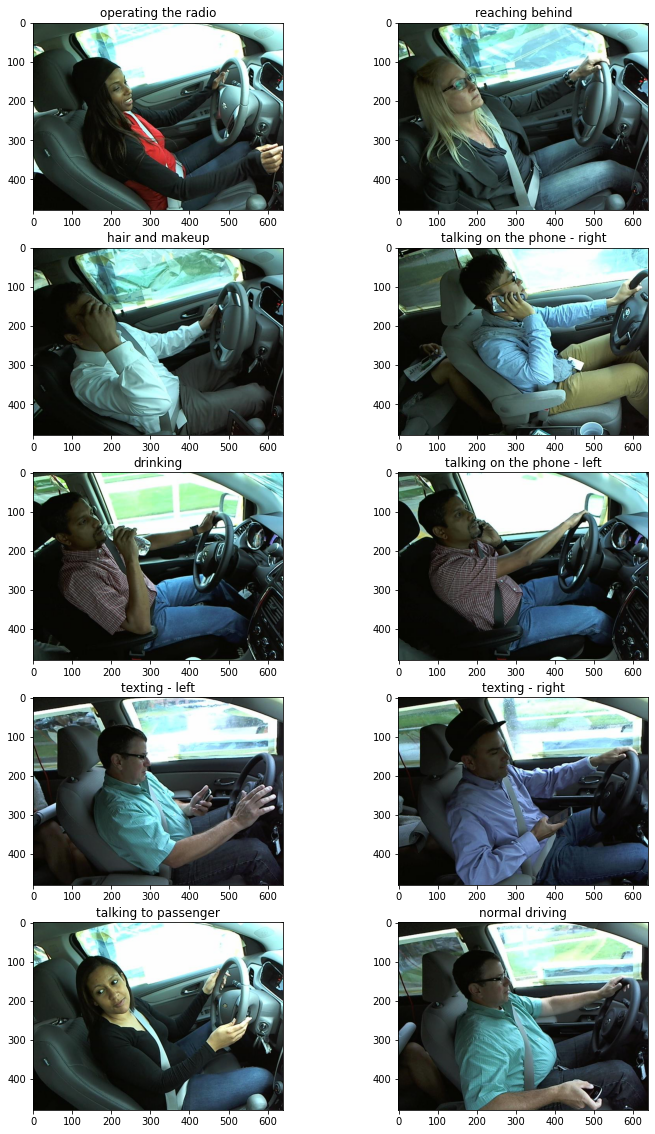

In [20]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

plt.figure(figsize = (12, 20))
image_count = 1
BASE_URL = '../input/state-farm-distracted-driver-detection/imgs/train/'
for directory in os.listdir(BASE_URL):
    if directory[0] != '.':
        for i, file in enumerate(os.listdir(BASE_URL + directory)):
            if i == 1:
                break
            else:
                fig = plt.subplot(5, 2, image_count)
                image_count += 1
                image = mpimg.imread(BASE_URL + directory + '/' + file)
                plt.imshow(image)
                plt.title(types[directory])

CNN MODEL

In [21]:
#https://www.kaggle.com/ismailchaida/cnn-to-detect-driver-actions

from keras.callbacks import ModelCheckpoint, EarlyStopping
batch_size = 50
nb_epoch = 5
models_dir = "saved_models"
if not os.path.exists(models_dir):
    os.makedirs(models_dir)
    
checkpointer = ModelCheckpoint(filepath='saved_models/weights_best.hdf5', 
                               monitor='val_loss', mode='min',
                               verbose=1, save_best_only=True)
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2)

In [22]:
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, GlobalAveragePooling2D

def cnn():
    cnnmodel = Sequential()

    cnnmodel.add(Conv2D(64,(3,3),activation='relu',input_shape=(64, 64, 1)))
    cnnmodel.add(BatchNormalization())

    cnnmodel.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    cnnmodel.add(Dropout(0.3))
    
    cnnmodel.add(Conv2D(128,(3,3),activation='relu',padding='same'))
    cnnmodel.add(BatchNormalization())

    cnnmodel.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    cnnmodel.add(Dropout(0.3))
    
    cnnmodel.add(Conv2D(256,(3,3),activation='relu',padding='same'))
    cnnmodel.add(BatchNormalization())

    cnnmodel.add(MaxPooling2D(pool_size=(2,2),padding='same'))
    cnnmodel.add(Dropout(0.5))

    cnnmodel.add(Flatten())
    cnnmodel.add(Dense(512,activation='relu'))
    cnnmodel.add(BatchNormalization())
    cnnmodel.add(Dropout(0.5))
    cnnmodel.add(Dense(128,activation='relu'))
    cnnmodel.add(Dropout(0.25))
    cnnmodel.add(Dense(10,activation='softmax'))
    
    return cnnmodel

In [23]:
from tensorflow import keras
cnnmodel = cnn()

cnnmodel.summary()
opt = keras.optimizers.Adam()
cnnmodel.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])

2021-12-07 23:47:40.846147: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:47:40.847234: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:47:40.847990: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-07 23:47:40.848875: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 62, 62, 64)        640       
_________________________________________________________________
batch_normalization (BatchNo (None, 62, 62, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 31, 31, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 31, 31, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 31, 31, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 31, 31, 128)       512       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 128)       0

In [24]:
import timeit
history = cnnmodel.fit(x_train, y_train, 
          validation_data=(x_test, y_test),
          epochs=nb_epoch, batch_size=batch_size, verbose=1)

2021-12-07 23:47:43.988746: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:185] None of the MLIR Optimization Passes are enabled (registered 2)


Epoch 1/5


2021-12-07 23:47:45.694208: I tensorflow/stream_executor/cuda/cuda_dnn.cc:369] Loaded cuDNN version 8005


359/359 [==============================] - 13s 16ms/step - loss: 1.2106 - accuracy: 0.5991 - val_loss: 0.2291 - val_accuracy: 0.9378
Epoch 2/5
359/359 [==============================] - 6s 15ms/step - loss: 0.3378 - accuracy: 0.8888 - val_loss: 0.1090 - val_accuracy: 0.9663
Epoch 3/5
359/359 [==============================] - 5s 15ms/step - loss: 0.1908 - accuracy: 0.9390 - val_loss: 0.1208 - val_accuracy: 0.9645
Epoch 4/5
359/359 [==============================] - 5s 15ms/step - loss: 0.1318 - accuracy: 0.9585 - val_loss: 0.0575 - val_accuracy: 0.9833
Epoch 5/5
359/359 [==============================] - 5s 15ms/step - loss: 0.1178 - accuracy: 0.9630 - val_loss: 0.0272 - val_accuracy: 0.9922


In [25]:
score = cnnmodel.evaluate(x_test, y_test, verbose=1)

141/141 [==============================] - 1s 4ms/step - loss: 0.0272 - accuracy: 0.9922


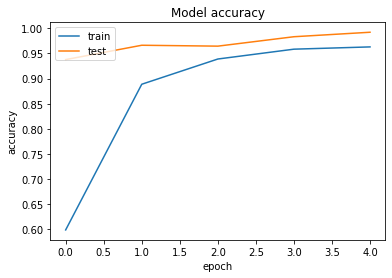

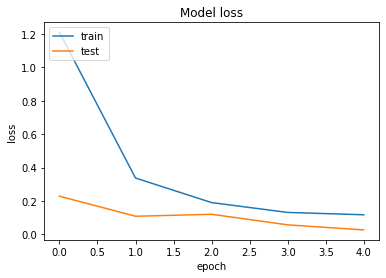

In [26]:
def plot(h):
    """
    Plot the validation accuracy and validation loss over epochs
    """
    # Summarize history for accuracy
    plt.plot(h.history['accuracy'])
    plt.plot(h.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # Summarize history for loss
    plt.plot(h.history['loss'])
    plt.plot(h.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    
plot(history)

In [27]:
#refrences

#https://www.kaggle.com/ismailchaida/cnn-to-detect-driver-actions
#https://www.kaggle.com/pierrelouisdanieau/computer-vision-tips-to-increase-accuracy
#https://towardsdatascience.com/building-a-convolutional-neural-network-cnn-in-keras-329fbbadc5f5
#https://www.analyticsvidhya.com/blog/2021/06/building-a-convolutional-neural-network-using-tensorflow-keras/